# Convolutional Neural Network`

In [1]:
# imports and plot customizations
import os
import sys
import pickle
import collections
import copy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time

class TimeClass():
    def __init__(self):
        pass
    def __enter__(self):
        self.start = time.time()
    def __exit__(self, type, value, traceback):
        self.end = time.time()
        self.elapsed = round(self.end - self.start, 2)
        print('\nFinished executing in {} seconds\n'.format(self.elapsed))

In [3]:
matplotlib.rcParams['xtick.color'] = 'grey'
matplotlib.rcParams['ytick.color'] = 'grey'
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['ytick.major.size'] = 7
# matplotlib.rcParams['xtick.labelsize'] = 10
# matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['xtick.minor.bottom'] = False
matplotlib.rcParams['ytick.minor.left'] = False
matplotlib.rcParams['figure.titlesize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.labelcolor'] = 'grey'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['xtick.major.pad'] = 8
matplotlib.rcParams['ytick.major.pad'] = 8
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['axes.edgecolor'] = 'grey'
matplotlib.rcParams['text.color'] = 'grey'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['legend.loc'] = 'upper left'
matplotlib.rcParams['figure.constrained_layout.h_pad'] = 0.12
matplotlib.rcParams['figure.constrained_layout.w_pad'] = 0.12

In [17]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

idx = np.random.choice(x_train.shape[0], 1000, replace = False)
n = 1000

x_train_sample = x_train[idx] / 255
y_train_sample = pd.get_dummies(y_train[idx]).values


x_test_sample = x_test / 255
y_test_sample = pd.get_dummies(y_test).values

In [18]:
class convolutional_neural_network:
    '''
    Arguments: 
        epoch_size (scalar, default = 1e2)
        alpha (scalar, default = 1e-3)
        hiddel_layer_dimension (integer, default = 10)
        dropout (boolean, default = True, whether to use the dropout regularization)
        dropout_probability (0 < float < 1)
        seed (numpy seed, default None)
        batch_size (integer, size of the minibatch, default = 1)
        kernel_rows (integer, default = 3)
        kernel_columns (integre, ddefault = 3)
        fit_stats (boolean, default = True)
    '''
    
    def __init__(self, **kwargs):
        self.epoch_size = int(kwargs.get('epoch_size', 1e2))
        self.alpha = kwargs.get('alpha', 1e-3)
        self.hidden_layer_dimension = kwargs.get('hidden_layer_dimension', 10)
        self.dropout = kwargs.get('dropout', True)
        self.dropout_probability = kwargs.get('dropout_probability', 0.5)
        self.seed = kwargs.get('seed', None)
        self.batch_size = kwargs.get('batch_size', 1)
        self.kernel_rows = kwargs.get('kernel_rows', 3)
        self.kernel_columns = kwargs.get('kernel_columns', 3)
        self.fit_stats = kwargs.get('fit_stats', True)
        
    def __repr__(self):
        return f'\
        neural_network(\
        epoch_size = {self.epoch_size}, \
        alpha = {self.alpha}, \
        hidden_layer_dimension = {self.hidden_layer_dimension}, \
        dropout = {self.dropout}, \
        dropout_probability = {self.dropout_probability}, \
        seed = {self.seed} \
        batch_size = {self.batch_size}\
        kernel_rows = {self.kernel_rows}\
        kernel_columns = {self.kernel_columns}\
        fit_stats = {self.fit_stats}\
        )'
        
    def _relu(self, x):
        return (x > 0) * x
    
    def _relu_derivate(self, x):
        return np.int8(x > 0)
    
    def _tanh(self, x):
        return np.tanh(x)
    
    def _tanh_derivate(self, x):
        return 1 - (x ** 2)
    
    def _softmax(self, x):
        x = np.exp(x)
        return x / np.sum(x, axis = 1, keepdims = True)
    
    def _split_data(self, X, y):
        # shuffle the dataset
        idx = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace = False)
        X = X[idx]
        y = y[idx]
        # split
        batches = int(X.shape[0] / self.batch_size)
        idx = np.int32(np.linspace(0, X.shape[0], batches, endpoint = True))
        idx = zip(idx[:-1], idx[1:])
        X_y_batches = [(X[start:end], y[start:end]) for start, end in idx]
        return X_y_batches
    
    def _dropout_mask(self, shape):
        mask = np.random.choice(
                        [0,1], 
                        shape, 
                        p = [self.dropout_probability, 1 - self.dropout_probability]
        )
        return mask
    
    def _sliding_kernel(self, X_batch):
        '''
        X_batch must have the dimensions of the original image (# images, rows, cols)
        '''
        kernel_list = []
        for row_start in range(X_batch.shape[1] - self.kernel_rows):
            for col_start in range(X_batch.shape[2] - self.kernel_columns):
                kernel = np.expand_dims(
                    X_batch[:, row_start:(row_start + self.kernel_rows), col_start:(col_start + self.kernel_columns)], 
                    axis = 1
                )
                kernel_list.append(kernel)
        expanded_kernels = np.concatenate(kernel_list, axis = 1)
        dims = expanded_kernels.shape
        flattened_kernels = expanded_kernels.reshape(dims[0] * dims[1], -1)
        return flattened_kernels
     
    def fit(self, X, y):  
        '''
        X (input matrix)
        y (response variable, must be matrix, if for regression, add a dimension to the vector y[:, np.newaxis])
        '''
        if self.seed:
            np.random.seed(self.seed)
        
        y_vector = np.argmax(y, axis = 1)
        
        weight_list = []
        error_list = []
        train_accuracy_list = []

        number_of_kernels = (X.shape[1] - self.kernel_rows) * (X.shape[2] - self.kernel_columns) * self.hidden_layer_dimension
        
        weights_0_1 = np.random.random((self.kernel_rows * self.kernel_columns, self.hidden_layer_dimension)) * 0.02 -0.01
        weights_1_2 = np.random.random((number_of_kernels, y.shape[1])) * 0.02 - 0.1

        for epoch in range(self.epoch_size):
            
            for X_batch, y_batch in self._split_data(X, y):
                # dot products
                layer_0 = self._sliding_kernel(X_batch)
                
                layer_1 = np.matmul(layer_0, weights_0_1)
                layer_1 = layer_1.reshape(X_batch.shape[0], -1)
                layer_1 = self._tanh(layer_1)
                if self.dropout:
                    mask = self._dropout_mask(layer_1.shape)
                    layer_1 *= mask * 1/self.dropout_probability
                
                layer_2 = np.matmul(layer_1, weights_1_2) 
                layer_2 = self._softmax(layer_2)

                # Deltas and backpropagation
                layer_2_delta = layer_2 - y_batch
                layer_1_delta = layer_2_delta.dot(weights_1_2.T) * self._tanh_derivate(layer_1)
                if self.dropout:
                    layer_1_delta *= mask
                    
                layer_1_delta = layer_1_delta.reshape(-1, self.hidden_layer_dimension)
                
                # Weights update
                weights_0_1 -= self.alpha * layer_0.T.dot(layer_1_delta)
                weights_1_2 -= self.alpha * layer_1.T.dot(layer_2_delta)
                self.weight = [weights_0_1, weights_1_2]
                weight_list.append(self.weight)
            
            # Classification scores (for each epoch)
            if self.fit_stats:
                epoch_prediction, epoch_prediction_vector = self.predict(X)

                train_accuracy = np.sum(epoch_prediction_vector == y_vector)  / X.shape[0]
                train_accuracy_list.append(train_accuracy)
                error = np.sum(np.linalg.norm(epoch_prediction - y, axis = 1) ** 2)
                error_list.append(error)

                sys.stdout.write(
                    "\r" +
                    " Epoch:" + str(epoch + 1) + "/" + str(self.epoch_size) +
                    ", Error (Sum of sq.):" + str(error)[0:5] + 
                    ", Train accuracy:" + str(train_accuracy)
                    )
                # Object update
                self.train_prediction = epoch_prediction
                self.train_prediction_vector = epoch_prediction_vector
                self.train_error = error_list
                self.train_accuracy = train_accuracy_list
            

        # Object update
        self.train_X = X
        self.train_y = y
        self.train_y_vector = y_vector
        self.weight_list = weight_list
        
    def predict(self, X):
        layer_0 = self._sliding_kernel(X)
                
        layer_1 = np.matmul(layer_0, self.weight[0])
        layer_1 = layer_1.reshape(X.shape[0], -1)
        layer_1 = self._tanh(layer_1)

        layer_2 = np.matmul(layer_1, self.weight[1]) 
        layer_2 = self._softmax(layer_2)

        self.test_prediction = layer_2
        
        self.test_prediction_vector = np.argmax(self.test_prediction, axis = 1)
        
        return (self.test_prediction, self.test_prediction_vector)
        
    
    def score_prediction(self, y, type = 'classification'):
        '''
        type ('classification' or 'sum_of_squares', default: 'classification')
        '''
        self.test_y = y
        self.test_y_vector = np.argmax(y, axis = 1)
        
        if not 'test_prediction' in dir(self):
            raise NameError('test_prediction object not found')
        
        if type == 'classification':
            correct_count = np.argmax(self.test_prediction, axis = 1) == np.argmax(y, axis = 1)
            test_score = np.sum(correct_count) / y.shape[0]
            self.test_score = test_score
            return test_score
        
        elif type == 'sum_of_squares':
            delta = self.test_prediction - y
            squares = np.linalg.norm(delta, axis = 1) **2
            sum_of_squares = np.sum(squares)
            self.test_score = sum_of_squares
            return sum_of_squares
        
    def plot_train_sum_of_squares(self):
        _, ax = plt.subplots(1,1, figsize = (4, 4))
        ax.plot(self.train_error, color = 'grey')
        ax.set_xlabel('Epoch', color = 'grey', fontsize = 15)
        ax.set_ylabel('Sum of squares', color = 'grey', fontsize = 15)

    def plot_train_sum_of_squares_vs_classification_accuracy(self):
        _, ax = plt.subplots(1,1, figsize = (4, 4))
        ax.plot(self.train_error, self.train_accuracy, color = 'grey')
        ax.set_xlabel('Sum of squares', color = 'grey', fontsize = 15)
        ax.set_ylabel('Accuracy', color = 'grey', fontsize = 15)
        
    def classification_heatmap(self, dataset = 'train', cmap = 'PRGn'):
        '''
        dataset ('train' or 'test' default = 'train')
        '''        
        tab1 = pd.crosstab(
            eval('self.' + dataset + '_y_vector'), 
            eval('self.' + dataset + '_prediction_vector'), 
            rownames = [dataset +' y'], colnames = [dataset + ' prediction'])

        fig, ax = plt.subplots(1,1,figsize = (5,5))
        im = ax.imshow(tab1.values,  cmap = cmap)

        for i in range(tab1.shape[0]):
            for j in range(tab1.shape[1]):
                text = ax.text(x = j, y = i, s = tab1.values[i, j], ha = "center", va = "center", color = "w")

        ax.set_xticks(range(tab1.shape[0]))
        ax.set_yticks(range(tab1.shape[0]))
        ax.set_xticklabels(range(tab1.shape[0]))
        ax.set_yticklabels(range(tab1.shape[0]))
        ax.set_ylabel(dataset + ' prediction', color = 'grey', fontsize= 15)
        ax.set_xlabel(dataset + ' y', color = 'grey', fontsize= 15)

        for edge, spine in ax.spines.items():
            spine.set_visible(False)

        ax.tick_params(which="minor", bottom=False, left=False)
        ax.set_xticks((np.arange(tab1.shape[0]) + 0.5)[:-1], minor=True)
        ax.set_yticks((np.arange(tab1.shape[0]) + 0.5)[:-1], minor=True)

        ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

    
    def boxplot_sum_of_squares_vs_class(self, dataset = 'train'):
        '''
        Only for single output node networks.
        dataset ('train' or 'test' default = 'train')
        '''
        dataset_test = pd.concat(
            [pd.Series(np.squeeze(eval('self.'+dataset+'_prediction'))), pd.Series(np.squeeze(eval('self.'+dataset+'_y')))], 
            axis = 1,
            keys = ['predicted', 'y']
        )
        bp1 = tuple(zip(*[[gr.predicted.values, nm] for nm, gr in dataset_test.groupby('y')]))
        
        _, ax = plt.subplots(1,1, figsize = (1.5,3))

        ax.boxplot(
            x = bp1[0],
            labels = bp1[1],
            widths = 0.6,
            capprops = dict(color='grey'), 
            boxprops = dict(color='grey'),
            whiskerprops = dict(color='grey'), 
            medianprops = {'color':'grey', 'linewidth':'2'}
        )

        ax.set_ylabel(dataset + ' prediction', color = 'grey', fontsize = 15)
        ax.set_xlabel(dataset+' y', color = 'grey', fontsize = 15)

In [19]:
with  TimeClass():
    nn3 = convolutional_neural_network(
        hidden_layer_dimension = 16, 
        epoch_size = 100, 
        alpha = 0.004, 
        batch_size = 20, 
        dropout_probability = 0.25,
        fit_stats = True
    )
    print(nn3)
    nn3.fit(x_train_sample, y_train_sample)

        neural_network(        epoch_size = 100,         alpha = 0.004,         hidden_layer_dimension = 16,         dropout = True,         dropout_probability = 0.25,         seed = None         batch_size = 20        kernel_rows = 3        kernel_columns = 3        fit_stats = True        )
 Epoch:100/100, Error (Sum of sq.):45.43, Train accuracy:1.03
Finished executing in 222.24 seconds



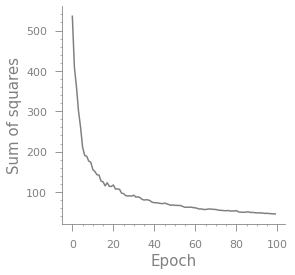

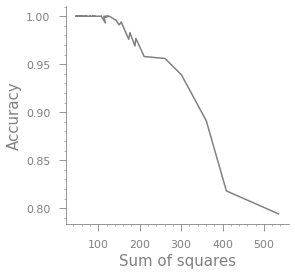

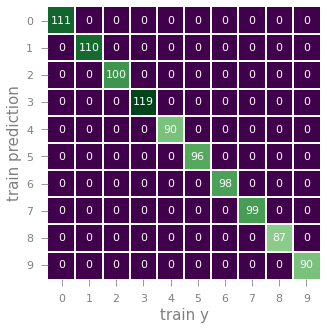

In [20]:
nn3.plot_train_sum_of_squares()
nn3.plot_train_sum_of_squares_vs_classification_accuracy()
nn3.classification_heatmap(dataset = 'train')

Test score:0.8625


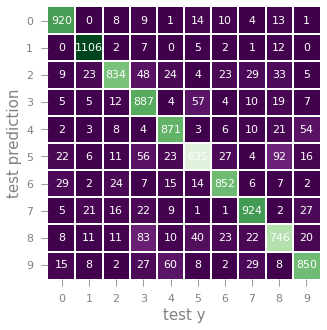

In [21]:
nn3.predict(x_test_sample)
nn3.score_prediction(y_test_sample)
print(f'Test score:{nn3.test_score}')
nn3.classification_heatmap(dataset = 'test')

The model fit runs slightly faster withouth comuting the extra stats

In [22]:
with  TimeClass():
    nn3 = convolutional_neural_network(
        hidden_layer_dimension = 16, 
        epoch_size = 100, 
        alpha = 0.004, 
        batch_size = 20, 
        dropout_probability = 0.25,
        fit_stats = False
        )
    print(nn3)
    nn3.fit(x_train_sample, y_train_sample)

        neural_network(        epoch_size = 100,         alpha = 0.004,         hidden_layer_dimension = 16,         dropout = True,         dropout_probability = 0.25,         seed = None         batch_size = 20        kernel_rows = 3        kernel_columns = 3        fit_stats = False        )

Finished executing in 186.17 seconds



# IMDB movie reviews

In [4]:
import itertools, re, collections

reviews = pd.read_csv('IMDB Dataset.csv')

reviews = reviews.replace(
    {'review':{r'<br />':' ', r'\s':' ', r'\W':' ', r'_':' ', r'\bs\b':'is', r'\bll\b':'will', r'\bm\b':'am', r'\bt\b':'not', r'\bdidn\b':'did', r'\s+':' '}, 
     'sentiment':{'positive':1, 'negative':0}
    }, 
    regex = True
)

reviews['review'] = reviews['review'].str.lower()
reviews['review'] = reviews['review'].str.split('\s+')
reviews['review'] = reviews.review.apply(lambda x: list(itertools.compress(x, [y != '' for y in x])))
reviews['review'] = reviews.review.apply(lambda x: list(itertools.compress(x, [not bool(re.search(r'.*\d+.*', y)) for y in x])))
reviews

,review,sentiment
0,"[one, of, the, other, reviewers, has, mentione...",1
1,"[a, wonderful, little, production, the, filmin...",1
2,"[i, thought, this, was, a, wonderful, way, to,...",1
3,"[basically, there, is, a, family, where, a, li...",0
4,"[petter, mattei, is, love, in, the, time, of, ...",1
...,...,...
49995,"[i, thought, this, movie, did, a, down, right,...",1
49996,"[bad, plot, bad, dialogue, bad, acting, idioti...",0
49997,"[i, am, a, catholic, taught, in, parochial, el...",0
49998,"[i, am, going, to, have, to, disagree, with, t...",0


In [5]:
train_fractin = 0.8
train_idx = pd.Index(np.random.choice(np.arange(reviews.shape[0]), size = int(reviews.shape[0] * train_fractin), replace = False))

train_words_list = reviews.review[train_idx].to_list()
train_y = reviews.sentiment[train_idx].values
test_words_list = reviews.review[reviews.index.difference(train_idx)].to_list()
test_y = reviews.sentiment[reviews.index.difference(train_idx)].values
len(train_y), len(test_y) 

(40000, 10000)

In [163]:
class sentence_processing_neural_network:
    '''
    Arguments: 
        epoch_size (scalar, default = 1e2)
        alpha (scalar, default = 1e-3)
        hiddel_layer_dimension (integer, default = 10)
        seed (numpy seed, default None)
        min_total_count (integer, discard words with fewer count, default = 2)
    '''
    
    def __init__(self, **kwargs):
        self.epoch_size = int(kwargs.get('epoch_size', 1e2))
        self.alpha = kwargs.get('alpha', 1e-3)
        self.hidden_layer_dimension = kwargs.get('hidden_layer_dimension', 10)
        self.seed = kwargs.get('seed', None)
        self.min_total_count = kwargs.get('min_total_count', 2)
        
    def __repr__(self):
        return f'\
        neural_network(\
        epoch_size = {self.epoch_size}, \
        alpha = {self.alpha}, \
        hidden_layer_dimension = {self.hidden_layer_dimension}, \
        seed = {self.seed} \
        min_total_count = {self.min_total_count}\
        )'
        
    def _relu(self, x):
        return (x > 0) * x
    
    def _relu_derivate(self, x):
        return np.int8(x > 0)
    
    def _tanh(self, x):
        return np.tanh(x)
    
    def _tanh_derivate(self, x):
        return 1 - (x ** 2)
    
    def _softmax(self, x):
        x = np.exp(x)
        return x / np.sum(x, axis = 1, keepdims = True)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _words_to_one_hot_encoding(self, words_list):
        cat1 = pd.CategoricalDtype(categories = self.words_set)
        def table_words(list):
            s1 = pd.Series(list, dtype=cat1)
            s1 = s1.value_counts(sort = False).values
            return s
        reviews_table = list(map(table_words, words_list))
        reviews_table = np.stack(reviews_table, axis = 0)
        total_counts = reviews_table.sum(axis = 0)
        count_threshold = 2
        words_pool = list(itertools.compress(words_pool, (pd.Series(total_counts) > count_threshold).to_list()))
        reviews_table = reviews_table[:, total_counts > count_threshold]
        total_counts = reviews_table.sum(axis = 0)
    
    def _extract_words_set(self, words_list):
        print('Extracting words set')
        '''
        words_list = list of lists (each element is a sentence where each element is a word)
        '''
        words_pool = list(itertools.chain.from_iterable(words_list))
        counts = collections.Counter(words_pool)
        words_set = [w for w, c in counts.items() if c > self.min_total_count]
        words_set = list(set(words_set))
        words_set = sorted(words_set)
        self.words_set = words_set
        return words_set
    
    def _words_to_index(self, words_list):
        print('Converting words to indexes')
        words_index = {}
        for i, word in enumerate(self.words_set):
            words_index[word] = i
        self.words_index = words_index

        input_word_indexes = list()
        for sentence in words_list:
            sentence_indexes = list()
            for word in sentence:
                sentence_indexes.append(words_index.get(word, None))
            sentence_indexes = [w for w in sentence_indexes if w != None]
            input_word_indexes.append(sentence_indexes)
        words_pool_indexes = list(itertools.chain.from_iterable(input_word_indexes))
        input_word_indexes = [list(set(s)) for s in input_word_indexes]
        self.input_word_indexes = input_word_indexes
        self.words_pool_indexes = words_pool_indexes
        return input_word_indexes
    
    
    def fit(self, words_list, y):  
        '''
        words_list = list of lists (each element is a sentence where each element is a word)
        y (response variable, must be a numpy array)
        '''
        if self.seed:
            np.random.seed(self.seed)
        
        weight_list = []
        error_list = []
        train_accuracy_list = []

        words_set = self._extract_words_set(words_list)
        input_word_indexes = self._words_to_index(words_list)
        
        weights_0_1 = np.random.random((len(words_set), self.hidden_layer_dimension)) * 0.02 -0.01
        weights_1_2 = np.random.random(self.hidden_layer_dimension) * 0.02 - 0.1

        print('Model fitting')
        for epoch in range(self.epoch_size):
            
            for i in range(len(words_list)):
                indexes = input_word_indexes[i]
                
                # dot products
                layer_1 = np.sum(weights_0_1[indexes], axis = 0)
                layer_1 = self._sigmoid(layer_1)
                layer_2 = np.dot(layer_1, weights_1_2) 
                layer_2 = self._sigmoid(layer_2)

                # Deltas and backpropagation
                layer_2_delta = layer_2 - y[i]
                #layer_1_delta = layer_2_delta.dot(weights_1_2.T)
                layer_1_delta = layer_2_delta * weights_1_2
                
                # Weights update
                weights_0_1[indexes] -= self.alpha * layer_1_delta
                weights_1_2 -= self.alpha * layer_1 * layer_2_delta
                self.weight = [weights_0_1, weights_1_2]
                weight_list.append(self.weight)
            
            
            # Epoch stats
            epoch_prediction, epoch_prediction_binary = self.predict(input_word_indexes = input_word_indexes)
            train_accuracy = np.sum(epoch_prediction_binary == y)  / len(y)
            train_accuracy_list.append(train_accuracy)
            error = np.linalg.norm(epoch_prediction - y) ** 2
            error_list.append(error)

            sys.stdout.write(
                "\r" +
                " Epoch:" + str(epoch + 1) + "/" + str(self.epoch_size) +
                ", Error (Sum of sq.):" + str(error)[0:5] + 
                ", Train accuracy:" + str(train_accuracy)
                )

        # Object update
        self.train_words_list = words_list
        self.train_y = y
        self.weight_list = weight_list
        self.weight = weight_list[-1]
        self.train_prediction = epoch_prediction
        self.train_error = error_list
        self.train_accuracy = train_accuracy_list
        self.train_prediction = epoch_prediction
        self.train_prediction_binary = epoch_prediction_binary
        
    def predict(self, words_list = None, input_word_indexes = None):
        if not input_word_indexes:
            input_word_indexes = self._words_to_index(words_list)
        y = list()
        for i in range(len(input_word_indexes)):
            indexes = input_word_indexes[i]
            layer_1 = np.sum(self.weight[0][indexes], axis = 0)
            layer_1 = self._sigmoid(layer_1)
            layer_2 = np.dot(layer_1, self.weight[1]) 
            layer_2 = self._sigmoid(layer_2)
            y.append(layer_2)
        y = np.array(y)
        y_binary = np.int8(np.round(y, 0))
        self.test_prediction = y
        self.test_prediction_binary = y_binary
        return y, y_binary

        
    
    def score_prediction(self, y, type = 'classification'):
        '''
        type ('classification' or 'sum_of_squares', default: 'classification')
        '''
        self.test_y = y
        
        if not 'test_prediction' in dir(self):
            raise NameError('test_prediction object not found')
        
        if type == 'classification':
            correct_count = np.sum(self.test_prediction_binary == y)
            test_score = np.sum(correct_count) / len(y)
            self.test_score = test_score
            return test_score
        
        elif type == 'sum_of_squares':
            sum_of_squares = np.linalg.norm(self.test_prediction - y) **2
            self.test_score = sum_of_squares
            return sum_of_squares
        
    def plot_train_sum_of_squares(self):
        _, ax = plt.subplots(1,1, figsize = (4, 4))
        ax.plot(self.train_error, color = 'grey')
        ax.set_xlabel('Epoch', color = 'grey', fontsize = 15)
        ax.set_ylabel('Sum of squares', color = 'grey', fontsize = 15)

    def plot_train_sum_of_squares_vs_classification_accuracy(self):
        _, ax = plt.subplots(1,1, figsize = (4, 4))
        ax.plot(self.train_error, self.train_accuracy, color = 'grey')
        ax.set_xlabel('Sum of squares', color = 'grey', fontsize = 15)
        ax.set_ylabel('Accuracy', color = 'grey', fontsize = 15)
        
    def boxplot_sum_of_squares_vs_class(self, dataset = 'train'):
        '''
        Only for single output node networks.
        dataset ('train' or 'test' default = 'train')
        '''
        dataset_test = pd.concat(
            [pd.Series(np.squeeze(eval('self.' + dataset + '_prediction'))), pd.Series(np.squeeze(eval('self.' + dataset + '_y')))], 
            axis = 1,
            keys = ['predicted', 'y']
        )
        bp1 = tuple(zip(*[[gr.predicted.values, nm] for nm, gr in dataset_test.groupby('y')]))
        
        _, ax = plt.subplots(1,1, figsize = (1.5,3))

        ax.boxplot(
            x = bp1[0],
            labels = bp1[1],
            widths = 0.6,
            capprops = dict(color='grey'), 
            boxprops = dict(color='grey'),
            whiskerprops = dict(color='grey'), 
            medianprops = {'color':'grey', 'linewidth':'2'},
            showfliers = False
        )

        ax.set_ylabel(dataset + ' prediction', color = 'grey', fontsize = 15)
        ax.set_xlabel(dataset+' y', color = 'grey', fontsize = 15)
        
    def similar(self, word):
        target_index = self.words_index[word]

        word_distances = {}
        for word_, index in self.words_index.items():
            raw_difference = self.weight[0][index] - self.weight[0][target_index]
            squared_difference = np.linalg.norm(raw_difference) ** 2
            word_distances[word_] = squared_difference
        word_distances = pd.Series(word_distances).sort_values(axis = 0)
        return word_distances


In [173]:
with TimeClass():
    nn4 = sentence_processing_neural_network(hidden_layer_dimension = 100, epoch_size = 80, alpha = 0.005)
    print(nn4)
    nn4.fit(words_list = train_words_list, y = train_y)

        neural_network(        epoch_size = 80,         alpha = 0.005,         hidden_layer_dimension = 100,         seed = None         min_total_count = 2        )
Extracting words set
Converting words to indexes
Model fitting
 Epoch:80/80, Error (Sum of sq.):2.478, Train accuracy:1.099975
Finished executing in 1343.85 seconds



In [181]:
with open('nn4.pickle', mode = 'wb') as f:
    pickle.dump(nn4, f)

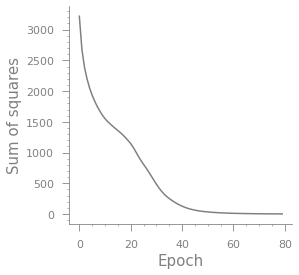

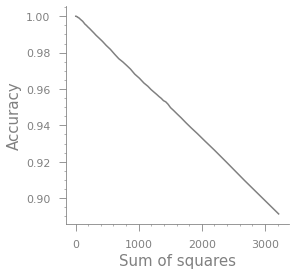

In [174]:
nn4.plot_train_sum_of_squares()
nn4.plot_train_sum_of_squares_vs_classification_accuracy()

Converting words to indexes
Test score:0.8708


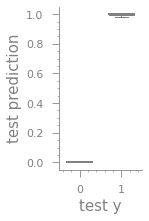

In [175]:
nn4.predict(words_list = test_words_list)
nn4.score_prediction(test_y)
print(f'Test score:{nn4.test_score}')
nn4.boxplot_sum_of_squares_vs_class(dataset = 'test')

In [178]:
print('top score:\n', nn4.similar('good').index[0:100], '\nworst scores:\n', nn4.similar('good').index[-100:-1])

top score:
 Index(['good', 'very', 'well', 'see', 'you', 'most', 'lot', 'still', 'know',
       'world', 'love', 'gets', 'nice', 'shows', 'hollywood', 'who', 'own',
       'got', 'each', 'family', 'things', 'together', 'parts', 'may',
       'expected', 'expect', 'match', 'eye', 'think', 'saw', 'time',
       'beginning', 'everyone', 'food', 'finally', 'meant', 'though', 'death',
       'episodes', 'fine', 'especially', 'although', 'new', 'while', 'always',
       'side', 'throughout', 'humor', 'course', 'howard', 'once', 'energy',
       'soon', 'second', 'west', 'different', 'mind', 'several', 'right',
       'meaningless', 'christopher', 'using', 'haven', 'rolled', 'adventures',
       'gives', 'enjoy', 'immersed', 'maddin', 'meaningful', 'nor', 'makes',
       'beat', 'clothes', 'true', 'porn', 'winner', 'legend', 'mikey',
       'comments', 'modern', 'special', 'recently', 'greatest', 'ramsey',
       'suicide', 'century', 'glimpse', 'octopussy', 'preformance', 'probably',
       

In [179]:
print('top score:\n', nn4.similar('bad').index[0:100], '\nworst scores:\n', nn4.similar('bad').index[-100:-1])

top score:
 Index(['bad', 'disappointed', 'saving', 'value', 'nowhere', 'titled',
       'potential', 'pretentious', 'mentions', 'research', 'sucked', 'dopey',
       'turkey', 'barely', 'artsy', 'looses', 'develops', 'prestigious',
       'attribute', 'bore', 'menu', 'segal', 'meyer', 'jello', 'gadgets',
       'sadly', 'mutilation', 'campy', 'irritatingly', 'yep', 'revenge',
       'shifting', 'confederate', 'interminable', 'cliche', 'bomb', 'seller',
       'drags', 'schtick', 'joel', 'monkey', 'geisha', 'caricatures',
       'screaming', 'embarrassingly', 'examine', 'fawlty', 'limp', 'preteens',
       'hostage', 'neither', 'choppy', 'grey', 'bigfoot', 'slows',
       'insightful', 'devon', 'coast', 'joaquin', 'ruined', 'legions',
       'smoking', 'ski', 'nielson', 'tasteless', 'unintended', 'identical',
       'railroad', 'costume', 'scalp', 'reverend', 'chuck', 'revisionist',
       'ana', 'shameless', 'distracting', 'unbearable', 'marisa', 'jews',
       'preceding', 'palmer', 

In [97]:
class words_association_neural_network:
    '''
    Arguments: 
        epoch_size (scalar, default = 1e2)
        alpha (scalar, default = 1e-3)
        hiddel_layer_dimension (integer, default = 50)
        seed (numpy seed, default None)
        min_total_count (integer, discard words with fewer count, default = 2)
        window (integer, default = 5)
        negative_selection (integer, default = 10)
    '''
    
    def __init__(self, **kwargs):
        self.epoch_size = int(kwargs.get('epoch_size', 1e2))
        self.alpha = kwargs.get('alpha', 1e-3)
        self.hidden_layer_dimension = kwargs.get('hidden_layer_dimension', 50)
        self.seed = kwargs.get('seed', None)
        self.min_total_count = kwargs.get('min_total_count', 2)
        self.window = kwargs.get('window', 5)
        self.negative_selection = kwargs.get('negative_selection', 5)
        
    def __repr__(self):
        return f'\
        neural_network(\
        epoch_size = {self.epoch_size}, \
        alpha = {self.alpha}, \
        hidden_layer_dimension = {self.hidden_layer_dimension}, \
        seed = {self.seed} \
        min_total_count = {self.min_total_count}\
        window = {self.window}\
        negative_selection = {self.negative_selection}\
        )'
        
    def _relu(self, x):
        return (x > 0) * x
    
    def _relu_derivate(self, x):
        return np.int8(x > 0)
    
    def _tanh(self, x):
        return np.tanh(x)
    
    def _tanh_derivate(self, x):
        return 1 - (x ** 2)
    
    def _softmax(self, x):
        x = np.exp(x)
        return x / np.sum(x, axis = 1, keepdims = True)
    
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def _words_to_one_hot_encoding(self, words_list):
        cat1 = pd.CategoricalDtype(categories = self.words_set)
        def table_words(list):
            s1 = pd.Series(list, dtype=cat1)
            s1 = s1.value_counts(sort = False).values
            return s
        reviews_table = list(map(table_words, words_list))
        reviews_table = np.stack(reviews_table, axis = 0)
        total_counts = reviews_table.sum(axis = 0)
        count_threshold = 2
        words_pool = list(itertools.compress(words_pool, (pd.Series(total_counts) > count_threshold).to_list()))
        reviews_table = reviews_table[:, total_counts > count_threshold]
        total_counts = reviews_table.sum(axis = 0)
    
    def _extract_words_set(self, words_list):
        print('Extracting words set')
        '''
        words_list = list of lists (each element is a sentence where each element is a word)
        '''
        words_pool = list(itertools.chain.from_iterable(words_list))
        counts = collections.Counter(words_pool)
        words_set = [w for w, c in counts.items() if c > self.min_total_count]
        words_set = list(set(words_set))
        words_set = sorted(words_set)
        self.words_set = words_set
        return words_set
    
    def _words_to_index(self, words_list):
        print('Converting words to indexes')
        words_index = {}
        for i, word in enumerate(self.words_set):
            words_index[word] = i
        self.words_index = words_index

        input_word_indexes = list()
        for sentence in words_list:
            sentence_indexes = list()
            for word in sentence:
                sentence_indexes.append(words_index.get(word, None))
            sentence_indexes = [w for w in sentence_indexes if w != None]
            input_word_indexes.append(sentence_indexes)
        words_pool_indexes = list(itertools.chain.from_iterable(input_word_indexes))
        input_word_indexes = [list(set(s)) for s in input_word_indexes]
        self.input_word_indexes = input_word_indexes
        self.words_pool_indexes = np.array(words_pool_indexes, dtype = 'int')
        return input_word_indexes
    
    
    def fit(self, words_list):  
        '''
        words_list = list of lists (each element is a sentence where each element is a word)
        y (response variable, must be a numpy array)
        '''
        if self.seed:
            np.random.seed(self.seed)
        
        weight_list = []
        error_list = []
        train_accuracy_list = []

        y = np.zeros(self.negative_selection + 1)
        y[0] = 1
        
        words_set = self._extract_words_set(words_list)
        input_word_indexes = self._words_to_index(words_list)
        
        weights_0_1 = np.random.random((len(words_set), self.hidden_layer_dimension)) * 0.2 -0.1
        weights_1_2 = np.zeros((self.hidden_layer_dimension, len(words_set)))
        
        print('Model fitting')
        for sentence in input_word_indexes * self.epoch_size:
            for i in range(len(sentence)):
                negative_selection_words = list(
                    self.words_pool_indexes[
                    (np.random.rand(self.negative_selection)*len(self.words_pool_indexes)).astype('int').tolist()]
                )
                target_i = [sentence[i]] + negative_selection_words

                left_context = sentence[max(0, i - self.window):i]
                right_context = sentence[(i + 1):min(len(sentence), i + self.window)]
                context_i = left_context + right_context                          

                # dot products
                layer_1 = np.mean(weights_0_1[context_i, :], axis = 0) # vector of size hidden_layer
                layer_2 = np.dot(layer_1, weights_1_2[:, target_i])
                layer_2 = self._sigmoid(layer_2)

                # deltas
                layer_2_delta = layer_2 - y
                layer_1_delta = np.dot(layer_2_delta, weights_1_2[:, target_i].T)

                # backpropagation
                weights_0_1[context_i, :] -= self.alpha * layer_1_delta
                weights_1_2[:, target_i] -= self.alpha * np.outer(layer_1, layer_2_delta)

            # weight update
            self.weight = [weights_0_1, weights_1_2]
            weight_list.append(self.weight)
            
        # Object update
        self.train_words_list = words_list
        self.weight_list = weight_list
        self.weight = weight_list[-1]
        
        
    def similar(self, word):
        target_index = self.words_index[word]

        word_distances = {}
        for word_, index in self.words_index.items():
            raw_difference = self.weight[0][index] - self.weight[0][target_index]
            squared_difference = np.linalg.norm(raw_difference) ** 2
            word_distances[word_] = squared_difference
        word_distances = pd.Series(word_distances).sort_values(axis = 0)
        return word_distances

    def analogy(self, positive, negative):
        norms = np.sum(self.weight[0] * self.weight[0], axis=1)
        norms = norms[:, np.newaxis]
        normed_weights = self.weight[0] * norms
        query_vect = np.zeros(self.weight[0].shape[1])
        for word in positive:
            query_vect += normed_weights[self.words_index[word]]
        for word in negative:
            query_vect -= normed_weights[self.words_index[word]]
        word_distances = {}
        for word, index in self.words_index.items():
            raw_difference = self.weight[0][index] - query_vect
            squared_difference = np.linalg.norm(raw_difference) ** 2
            word_distances[word] = squared_difference
        word_distances = pd.Series(word_distances).sort_values(axis = 0)
        return word_distances


In [299]:
with TimeClass():
    nn5 = words_association_neural_network(hidden_layer_dimension = 50, epoch_size = 30, alpha = 0.05, negative_selection = 10, window = 8)
    print(nn5)
    nn5.fit(words_list = train_words_list)

        neural_network(        epoch_size = 30,         alpha = 0.05,         hidden_layer_dimension = 50,         seed = None         min_total_count = 2        window = 8        negative_selection = 10        )
Extracting words set
Converting words to indexes
Model fitting

Finished executing in 24155.3 seconds



In [306]:
with open('nn5.pickle', mode = 'wb') as f:
    pickle.dump(nn5, f)

In [300]:
print('top score:\n', nn5.similar('bad').index[0:100], '\nworst scores:\n', nn5.similar('bad').index[-100:-1])

top score:
 Index(['bad', 'awful', 'fishes', 'eegah', 'mets', 'throughout', 'suitable',
       'girolami', 'eure', 'embodying', 'devere', 'dbz', 'choco', 'cosette',
       'xtian', 'waterfalls', 'tombstones', 'hearsay', 'flow', 'trancer',
       'infront', 'goads', 'poindexter', 'kohli', 'paramilitary', 'tomcat',
       'trilogy', 'complete', 'nastie', 'rubbish', 'refer', 'gavan', 'cray',
       'soso', 'arun', 'weight', 'main', 'disarmament', 'haseena', 'five',
       'tarnishes', 'bhagam', 'hoffner', 'medias', 'lucasarts', 'fantine',
       'cottonmouth', 'anesthesiologist', 'managed', 'twenty', 'papi',
       'sometimes', 'ungodly', 'covers', 'peacemaker', 'avril', 'protaganist',
       'halal', 'sakai', 'took', 'lucia', 'blackmer', 'theby', 'colorization',
       'willpower', 'workman', 'itches', 'please', 'lazer', 'balki',
       'hudsucker', 'thinking', 'interned', 'corsia', 'sarafina', 'dennehey',
       'touching', 'adulterers', 'treadstone', 'deknight', 'marley',
       'creat

In [301]:
print('top score:\n', nn5.analogy(['elizabeth','man'],['woman']).index[0:100])

top score:
 Index(['man', 'twilight', 'rushing', 'the', 'bambi', 'protesters', 'juliana',
       'sho', 'bluto', 'madcap', 'ppv', 'outdoor', 'cabinet', 'danced',
       'quake', 'freezing', 'hoc', 'bert', 'nap', 'stinging', 'accompany',
       'romantically', 'spills', 'miners', 'bullied', 'manifested',
       'imbeciles', 'exclaims', 'braga', 'addressing', 'org', 'warns',
       'compensate', 'censor', 'seann', 'edie', 'brady', 'janet', 'voters',
       'taliban', 'superintendent', 'northern', 'caligula', 'contend',
       'angrily', 'annabella', 'palestinian', 'rejuvenation', 'mccrea',
       'sting', 'brainwashing', 'bon', 'sponsor', 'corners', 'homeward',
       'animatronics', 'we', 'euro', 'happier', 'exhibited', 'pew', 'lap',
       'courtroom', 'harass', 'thirteenth', 'cactus', 'shifting', 'latina',
       'umeki', 'visualize', 'they', 'fudd', 'evidences', 'michelangelo',
       'comforts', 'mobutu', 'swimsuit', 'fishing', 'csi', 'perpetrator',
       'scantily', 'norwegians', 

In [302]:
def extract_words_per_node(words_index, weight, indexes):
    x = np.apply_along_axis(
        lambda x: np.array(list(words_index.keys()))[x.argsort(axis = 0)[indexes]], 
        axis = 0, 
        arr = weight
    ).T
    return x

In [303]:
for i, node in enumerate(extract_words_per_node(nn5.words_index, nn5.weight[0], range(-100, -1))):
    print('node: ', i, '\n', node)

node:  0 
 ['leo' 'bulgaria' 'saddens' 'potent' 'jamming' 'ichikawa' 'scrutiny'
 'ancestry' 'semitic' 'modulated' 'dolemite' 'hinds' 'acres' 'athens'
 'superpower' 'marylee' 'grahame' 'traders' 'spiner' 'raid' 'hermione'
 'sennett' 'sacrifices' 'sabu' 'republican' 'chickens' 'skelton' 'cock'
 'external' 'laboured' 'cyborgs' 'disability' 'matthias' 'practices'
 'jannings' 'bode' 'interrupt' 'praised' 'chapa' 'perceptions' 'curtain'
 'laird' 'institutions' 'framing' 'arab' 'slater' 'intrepid'
 'intermittent' 'marshal' 'reckoned' 'esque' 'suburb' 'fireman'
 'idiosyncratic' 'mercurial' 'alienating' 'advises' 'hawkins' 'the'
 'sneering' 'boulevard' 'relates' 'waco' 'truths' 'heretic' 'dixon'
 'peers' 'selfless' 'succeeding' 'strapped' 'dystrophy' 'not'
 'suprisingly' 'illuminated' 'seller' 'mulroney' 'pastor' 'stubbornness'
 'mutilated' 'ubiquitous' 'victimized' 'tactical' 'bakhtiari' 'outlet'
 'bolts' 'undaunted' 'feds' 'porgy' 'tactic' 'it' 'paymer' 'mansfield'
 'tadzio' 'napoleonic' 'unt

In [304]:
class similar_sentences:
    '''
    Takes a neural network object and a list of query words and finds the train sentences that are the closest to the query.
    '''
    def __init__(self, neural_network, query_words, **kwargs):
        '''
        neural_network
        query_words
        top_sentences (integer, default = 10)
        '''
        self.neural_network = neural_network
        self.query_words = query_words
        self.top_sentences = int(kwargs.get('top_sentences', 10))
    
    def normalize_weight(self):
        norms = np.sum(self.neural_network.weight[0] ** 2, axis=1)
        norms.resize(norms.shape[0],1)
        normed_weights = self.neural_network.weight[0] * norms
        self.normed_weights = normed_weights
        return normed_weights

    def make_sent_vect(self, words):
        indices = list(
            map(
                lambda x: self.neural_network.words_index[x], # get the numeric indexes
                filter(lambda x: x in self.neural_network.words_index, words) # use only words that are in the dataset
            )
        )
        return np.mean(self.normed_weights[indices],axis=0)

    def extract_dataset_word_vector(self):
        dataset_word_vector = list()
        for sentence in self.neural_network.train_words_list:
            dataset_word_vector.append(self.make_sent_vect(sentence))
        dataset_word_vector = np.array(dataset_word_vector)
        self.dataset_word_vector = dataset_word_vector
        return dataset_word_vector
    
    def most_similar_dataset_sentence(self):
        self.query_words_vector = self.make_sent_vect(self.query_words)
        scores = collections.Counter()
        for i, val in enumerate(self.dataset_word_vector.dot(self.query_words_vector)):
            scores[i] = val
        most_similar = list()
        for idx, score in scores.most_common(self.top_sentences):
            most_similar.append(self.neural_network.train_words_list[idx])
        self.most_similar = most_similar
        return most_similar
    
    def fit(self):
        self.normalize_weight()
        self.extract_dataset_word_vector()
        self.most_similar_dataset_sentence()
        
        for s in self.most_similar:
            print(' '.join(s), '\n')
            
    def plot_vector(self):
        _, ax = plt.subplots(1,1, figsize = (6,4))
        ax.scatter(range(0, len(self.query_words_vector)), self.query_words_vector, c = 'grey')
        ax.set_ylabel('node\'s mean', color = 'grey', fontsize = 15)
        ax.set_xlabel('node', color = 'grey', fontsize = 15)

this is quite possibly the worst sequel ever made the script is unfunny and the acting stinks the exact opposite of the original 

horrid the special effects make the tv version of tremors look real no one in the cast can act kind of like the voyage to the bottom of the sea meets the cartoon ocean going electric eel cartoons 

pakeezah is in my mind the greatest achievement of indian cinema the film is visually overwhelming but also emotionally breathtaking the music the songs the sets the costumes the cinematography in fact every creative element is worthy of superlatives 

this is the very la nouvelle vague one of the best films of the new wave and i dare say one of the first ten ever made why the atmosphere the story the actors actress are all brilliant this is the theater a fairy tale the life the film paris thank you mr rivette 

in the tower of babel installment of the mini series the narrator describes the builders of the tower as the descendants of moses that is like saying geo

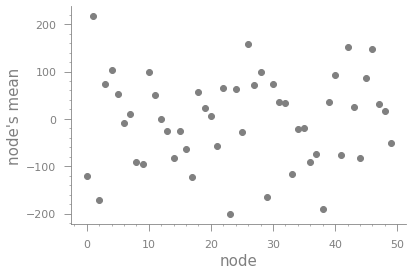

In [305]:
s1 = similar_sentences(nn5, query_words = ['boring','awful', 'terrible', 'horrible'], top_sentences = 10)
s1.fit()
s1.plot_vector()